In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using Theano backend.


## Introduction
Technical analysis is a trading discipline used to evaluate investments and identify trading opportunities in price trends and patterns from graphs.  Technical analysts believe past trading activity and price changes of a stock can be valuable indicators of the security's future price movements.  The difference between 
technical analysis and fundamental analysis is that fundamental analyats focuses on a company's financials rather than historical price patterns or stock trends.  https://www.investopedia.com/terms/t/technicalanalysis.asp
This notebook will demonstrate how to perform a very basic technical analysis of stock prices using Python code.  I will provide analysis and insights of stock prices that can be obtained from historical stock data and corresponding graphs.  In addition, this notebook will demonstrate how algorithmic trading can be used to predict stock prices and how technical indicators can used with LTSM models.  <br>
I obtained historical stock data by using the Pandas library DataReader.  The library provides price and volumne information regarding stocks. I will use mainly the Closing Pricefrom the datasets.<br>
I will use Long Short Term Memory (LSTM ) and SARIMA models to forecast the next day stock price.  I will use  metrics to measure the performance of the models at predicting stock prices.  
My analysis will focus the following pharmaceutical companies that are developing a COVID-19 vaccine: 
* Pfizer(PFE),
* Johnson & Johnson(JNJ)
* Moderna (MRNA)
* Novavax (NVAX) 
* BioNTech SE(BNTX)
* MERCK & Co.(MRK)


### Question 1: 
Can technical indicators provide an investor or trader with information to make a decision of when to buy and sell stocks? If yes, what kind of information can be provided.  A question to consider is what type of investment is being sought?  Are you looking for short investments with high returns or long term investment with consistent returns.<br>
**Model 1** consists of historical price change analyses.<br>
I will use Moving Averages, prices changes and MACD to analyze price trends.  
### Question 2:
How well can historical data  and algorithms predict future stocks prices?  I will contrast the performance of predictions of LSTM models and LTSM models with technical indicators.  Is there a difference in the RMSE metrics when comparing models?<br>
**Model 1** I will use a LTSM Neural Network to make a price prediction with only historical price data.<br>
**Model 2** LTSM model with technical indicators to predict and graph future stock prices.<br>
### Question 3:
Which trading algorithms LTSM or ARIMA performs better at predicting stocks prices?  
**Model 1** is an ARIMA model.<br>
### Question 4:
Is there a relationship between tweets put out by the pharmaceutical companies and the fluctuation in their stock prices.<br>




## Get the Historical Stock Data

### Multiple Stocks Data

In [2]:
from datetime import date
today = date.today()
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            plt.title("HistoricL Stock Adjusted Price Data")
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


In [3]:
# multi_stock_data = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=True, stock_value='Adj Close')
# multi_stock_data;

In [4]:
#multi_stock_data.to_csv('multi_pharm_data')

In [5]:
#start='2017',end='today'
multi_stocks = pd.read_csv('multi_pharm_data', parse_dates=True, index_col='Date')
#multi_stocks

In [6]:
def get_multi_plot(df, stock_value=None):
    #plt.figure(figsize=(12,8))
    df.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel('Close Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
    return df
    

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,104.081535,25.400000,NaN,23.886580,NaN
2017-01-04,26.887548,103.910828,26.200001,NaN,24.076221,NaN
2017-01-05,27.146002,104.998009,26.400000,NaN,24.731359,NaN
2017-01-06,27.041008,104.494850,27.400000,NaN,24.507233,NaN
2017-01-09,27.032928,104.476868,28.400000,NaN,24.593435,NaN
...,...,...,...,...,...,...
2021-02-08,34.820000,164.919998,319.929993,185.979996,50.060001,119.500000
2021-02-09,34.970001,166.270004,315.869995,179.520004,50.410000,117.529999
2021-02-10,34.740002,166.809998,298.359985,179.339996,49.970001,119.349998


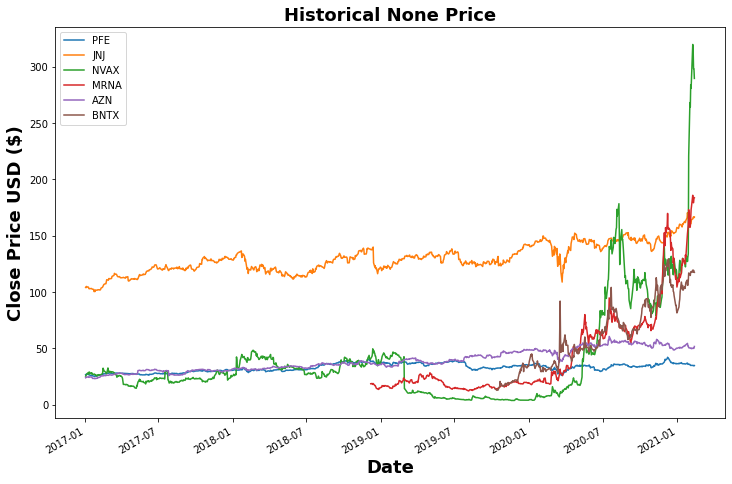

In [7]:
get_multi_plot(multi_stocks)

### Single Stock Data

In [8]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single

    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Dataframe has 1040 rows and 6 columns



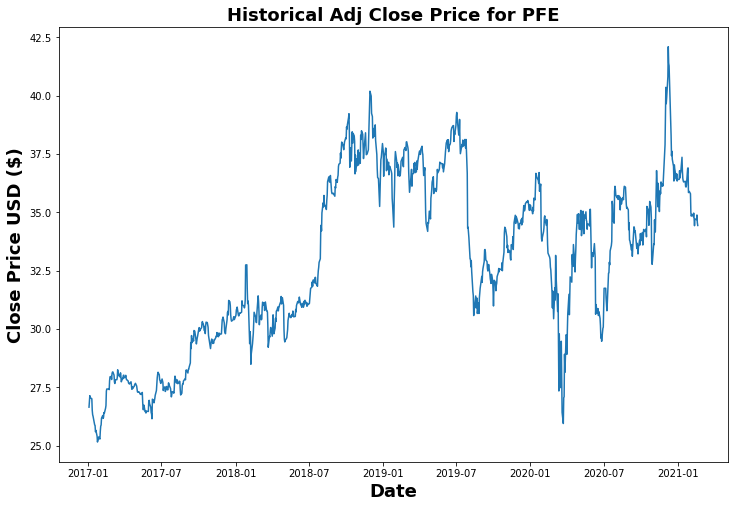

In [9]:
start='01-01-2019'
end='today'
pfe_stock = single_stock_data('PFE', start='01-01-2017',end='today',plot=True,stock_value='Adj Close')

In [10]:
#pfe_stock.to_csv('pfe_stock')
pfe_stock_data = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#single_stock['Close']['2015-04-01':'2015-12-01'].plot()
pfe_stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928
...,...,...,...,...,...,...
2021-02-12,34.950001,34.360001,34.439999,34.720001,25513100.0,34.720001
2021-02-16,34.860001,34.560001,34.849998,34.689999,28668400.0,34.689999
2021-02-17,35.000000,34.459999,34.570000,34.889999,26389400.0,34.889999


In [11]:
pfe_stock_data['Adj Close'].describe()

count    1040.000000
mean       32.850950
std         3.707581
min        25.159119
25%        29.999429
50%        33.001329
75%        36.119614
max        42.101986
Name: Adj Close, dtype: float64

## Technical Indicators
The pratice of analyzing and executing stock trades is becoming increasingly automated with algorithimic trading.  The usage of technnical indicators is a part of algorithmic trading. What are technical indicators and how are used by Technical Analyst in stock trading?  Technical indicators are approaches or pattern-based signals produced by the price, volume, and/or open interest of a stock which are used by traders who follow technical analysis.  Technical analysts believe past trading activity and price changes of a security can be valuable indicators of the security's future price movements.https://www.investopedia.com/terms/t/technicalindicator.asp<br>Technical analysts look for indicators in the historical data and use them to predict future price movements.  The analysts also use them to look for entry and exit points in markets to conduct trades.  I will discuss popular technical indicators that are used in the markets to study price movements:

1. Moving Averages (MA)
2. Exponential Moving Average (EMA)
3. Rate of Change (ROC)

### Moving Averages
The moving average is also known s the rolling mean or running average.  Moving averages smooth the curve by filtering out the noise inorder to highlight components in the data such as trends and seasonality.  The moving Average smooths out the variations in the dataset by calculating the moving average.  Three common types of moving averages are Simple Moving Average (SMA), Weighted Moving Average (WMA) and Exponential Moving Average (EMA).  The commonly used moving averages are 5, 10, 20, 50, 200 day moving averages.  For example, a 10 period SMA would be over 10 periods and woud mean 10 trading days).
<br>

#### Simple Moving Average
The Simple Moving Average is the arithmetic mean of all the stock prices or the sum of all the stock prices divided by the number of periods.  We can use the rolling method to calcualte moving averages.<br>
<br>
The below plot shows alot of fluctuations and noise in the stock price.  The plot shows the average stock price with the 10 and 20-year moving averages.<br>
Aound 2/18, there was a spike in price from \\$35.00 to \\$37.5 and then dropped quickly to almost $31.00.  SMA is helpfl in these instances becuase it gives a more realistic picture of what happened with stoc k price. It may have increased quickly but what were the 10 and 20 day averages around this time period for a more accurate picute of the price.<br>
Around 8/2019, the price was pretty volatile.  The SMA smooths out the noise and gives a more accurate picture.<br>

In [12]:
rolling_method = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#how big should the subset of data be that we're calculating the moving average on?
rolling_method['MA_10'] = rolling_method.Close.rolling(10).mean()
rolling_method['MA_50'] = rolling_method.Close.rolling(50).mean()
rolling_method #['2017-01-01':'2021-2-19']

,High,Low,Open,Close,Volume,Adj Close,MA_10,MA_50
Date,,,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324,NaN,NaN
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548,NaN,NaN
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002,NaN,NaN
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008,NaN,NaN
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-02-12,34.950001,34.360001,34.439999,34.720001,25513100.0,34.720001,34.912,37.3150
2021-02-16,34.860001,34.560001,34.849998,34.689999,28668400.0,34.689999,34.801,37.1928
2021-02-17,35.000000,34.459999,34.570000,34.889999,26389400.0,34.889999,34.791,37.0888


In [13]:
rolling_method['Close'].describe(), rolling_method['MA_50'].describe()

(count    1040.000000
 mean       35.598118
 std         3.320764
 min        27.030361
 25%        33.377609
 50%        34.853586
 75%        37.945919
 max        43.861481
 Name: Close, dtype: float64,
 count    991.000000
 mean      35.706698
 std        2.998294
 min       31.284440
 25%       33.890418
 50%       34.772106
 75%       37.721625
 max       41.757495
 Name: MA_50, dtype: float64)

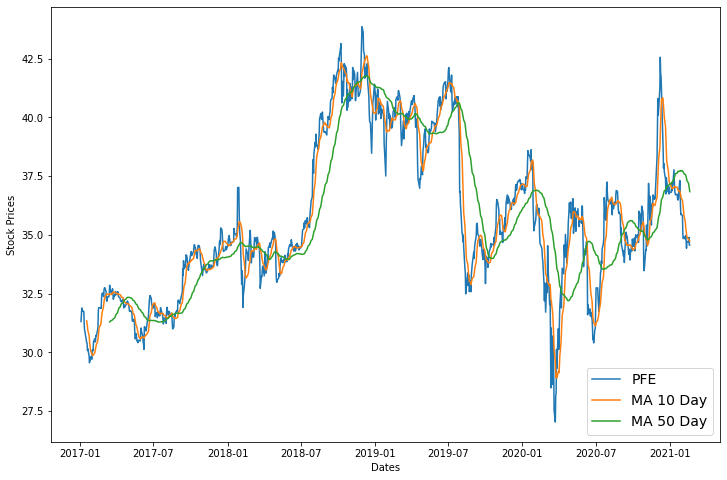

In [14]:
plt.figure(figsize=(12,8))
plt.plot(rolling_method['Close'], label='PFE')
plt.plot(rolling_method['MA_10'], label='MA 10 Day')
plt.plot(rolling_method['MA_50'],label='MA 50 Day')
plt.xlabel('Dates')
plt.ylabel('Stock Prices')
plt.legend(loc='lower right', fontsize=14)

#### Exponential Moving Average (EMA)
 The EMA is also referred to as the exponentially weighted moving average.  The difference between EMA and SMA is that SMA assigns equal weight to all periods.  Whereas, with EMA the latest prices are given higher weights and it assigns lesser weight to past data.  EMA is used more by short term traders because it is quicker to react to price changes compared to SMA which is slower. this technical indicator is used to produce buy and sell signals based on crossovers and divergences from the historical average.  https://www.investopedia.com/terms/e/ema.asp<b>
When red line crosses above the green line you see a increase in the price and every time the red drops below the EMA26 you see the price decrease.

In [15]:
pfe_df = pfe_stock_data.copy()

In [16]:
# #single_stock
# #good time of when to buy stockand when to sell it
# #three moving avrages
# #short/fast exponential moving ma
def create_ema_fuction(data, col='Close',span1=None,span2=None,span3=None):
    data['shortEMA'] = data[col].ewm(span=span1, adjust=False).mean() #5 time periods
    #calculate middle/medium exponential moving ma
    data['middleEMA'] = data[col].ewm(span=span2, adjust=False).mean() #5 time periods
    #calculate long/slow exponential moving ma
    data['longEMA'] = data[col].ewm(span=span3, adjust=False).mean() #5 time periods
    
    #visulaize closing price and exponential moving average
    plt.figure(figsize=(12,6))
    plt.plot(data[col],label='Close Price', color='blue')
    plt.plot(data['shortEMA'],label='Short/Fast EMA', color='red')
    plt.plot(data['middleEMA'],label='Middle/medium EMA', color='orange')
    plt.plot(data['longEMA'],label='Long/slow EMA', color='green')
    plt.title('Exponential Moviing Average Plot')
    plt.xlabel('Dates')
    plt.ylabel('Closing Price')
    plt.legend()
    
    return data #, shortEMA, middleEMA,longEMA

,High,Low,Open,Close,Volume,Adj Close,shortEMA,middleEMA,longEMA
Date,,,,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324,31.309298,31.309298,31.309298
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548,31.401012,31.334311,31.317896
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002,31.563357,31.384650,31.335713
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008,31.630473,31.419201,31.349119
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928,31.672055,31.449748,31.361810


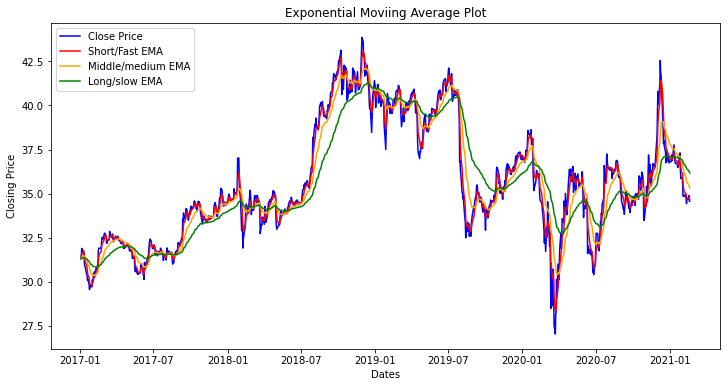

In [17]:
ewma1 = create_ema_fuction(data=pfe_df, span1=5, span2=21,span3=63)
ewma1.head()

#### Exponential Moving Average Crossover Stratergy
There are several ways in which stock market analysts and investors can use moving averages to analyse price trends and predict upcoming change of trends. One in particular Exponential Moving Average Crossover strategy.  a moving-average crossover occurs when on plotting, the two moving averages each based on different time-periods tend to cross. This indicator uses two (or more) moving averages — a faster moving average(short-term) and a slower(long-term) moving average. The faster moving average may be 5-, 10- or 25-day period while the slower moving average can be 50-, 100- or 200-day period. A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes. On the other hand, a long-term moving average is deemed slower as it encapsulates prices over a longer period and is more lethargic.<br>
A crossover occurs when a faster moving average (i.e. a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In stock trading, this meeting point can be used as a potential indicator to buy or sell an asset.
When the short term moving average crosses above the long term moving average, this indicates a buy signal.
Contrary, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.<br>
moving average has crossed above the long-term(slower) moving average, thereby triggering a buy call.
When ‘Position’ = -1, it implies that the Signal has changed from 1 to 0 meaning a short-term(faster) moving average has crossed below the long-term(slower) moving average, thereby triggering a sell call.



In [18]:
#function to buy and sell the stock
#buy sell signals
def buy_sell_function(data):
    buy_list = []
    sell_list=[]
    flag_long = False
    flag_short = False

    for i in range(0, len(data)):
        if data['middleEMA'][i] < data['longEMA'][i] and data['shortEMA'][i]< data['middleEMA'][i] and flag_long== False and flag_short== False:
                #this is when to buy stock
                buy_list.append(data['Close'][i])
                sell_list.append(np.nan)
                flag_short = True
        #sell if the short/fast moving average crosses above the middle moving average
        elif flag_short == True and data['shortEMA'][i] > data['middleEMA'][i]:
            sell_list.append(data['Close'][i])
            buy_list.append(np.nan)
            flag_short = False
            
        elif data['middleEMA'][i] > data['longEMA'][i] and data['shortEMA'][i]> data['middleEMA'][i] and flag_long== False and flag_short== False:
                #this is when to buy stock
                buy_list.append(data['Close'][i])
                sell_list.append(np.nan)
                flag_long = True
        #sell if the short/fast moving average crosses above the middle moving average
        elif flag_long == True and data['shortEMA'][i] < data['middleEMA'][i]:
            sell_list.append(data['Close'][i])
            buy_list.append(np.nan)
            flag_long = False 
        else:
            #if conditions not met for any statement just append to buy, sell lists a nan value
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
           
    return buy_list, sell_list       
            

In [19]:
#add buy and sell signals to dataset
ewma1['Buy'] = buy_sell_function(pfe_df)[0] #return index 0
ewma1['Sell'] = buy_sell_function(pfe_df)[1] #return inddex 1

In [20]:
def ema_signals_function(data):
    plt.figure(figsize=(12,8))
    plt.plot(data['Close'],label='Close Price', color='blue',alpha=0.35)
    plt.plot(data['shortEMA'],label='Short/Fast EMA', color='red',alpha=0.35)
    plt.plot(data['middleEMA'],label='Middle/medium EMA', color='orange',alpha=0.35)
    plt.plot(data['longEMA'],label='Long/slow EMA', color='green',alpha=0.35)
    plt.scatter(data.index,data['Buy'], color='green', marker='^', alpha=1)
    #prices are going to go down
    plt.scatter(data.index,data['Sell'], color='red',marker='v',alpha=1)
    plt.title('Buy and Sell Graph')
    plt.legend() 

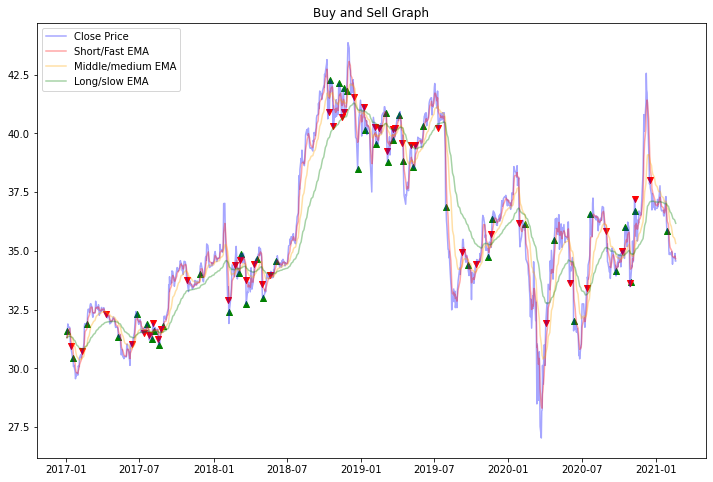

In [21]:
ema_signals_function(data=ewma1)

## Rate of Change
### Historical Price Change Analysis
Volatility is the range of price changes a security experiences over a given period of time. If the price stays relatively stable, the security has low volatility. A highly volatile security hits new highs and lows quickly, moves erratically, and has rapid increases and dramatic falls.  Is volatility in price good or bad for trading? As the price fluctuates, it provides the opportunity for investors to buy stock in a solid company when the price is very low, and then wait for cumulative growth down the road.https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp

### Price Change in Dollars
Add column to calculate actual change in dollars<br>
To see how big the changes were on a daily basis we subtract yesterday's closing price yesterday from today.  This will show the change in price.  For example, we can see that on 1/3 the Closing price was 39.886147 and on 1/2 the Closing price was 41.034157 so the price decreased -$1.148.<br> 
Expected change (1 std deviaiton movement in price)<br>
Column of calculation of how big the actual changes was interms of standard deviations.<br>
Histograms changes in standard deviaiton<br>
Scatterplot of absolute value of magnitude change vs. actual change. Let's us see how the price changes daily.<br>

In [22]:
# sdr = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=False, stock_value='Adj Close')
# sdr
price_change = pfe_stock_data.copy()

In [23]:
#leavr off 1 b/c that's default value
#using shift function
#price decreased by -$1.148

price_change['Actual_Changes'] = price_change['Close'] - price_change['Close'].shift(1)
# price_change['Expected_Changes'] =price_change['Close'] * #std deviation or 21 day 
price_change

,High,Low,Open,Close,Volume,Adj Close,Actual_Changes
Date,,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324,NaN
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548,0.275143
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002,0.303606
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008,-0.123341
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928,-0.009487
...,...,...,...,...,...,...,...
2021-02-12,34.950001,34.360001,34.439999,34.720001,25513100.0,34.720001,0.290001
2021-02-16,34.860001,34.560001,34.849998,34.689999,28668400.0,34.689999,-0.030003
2021-02-17,35.000000,34.459999,34.570000,34.889999,26389400.0,34.889999,0.200001


The below graph shows that for the stated time the stock price never increased more than 3.00 and did not decrease more than -3.00.<br>

In [24]:
#the mean (average) change was less than 1 cent
price_change['Actual_Changes'].describe() 

count    1039.000000
mean        0.003138
std         0.508999
min        -2.590134
25%        -0.203985
50%         0.009487
75%         0.237190
max         2.656548
Name: Actual_Changes, dtype: float64

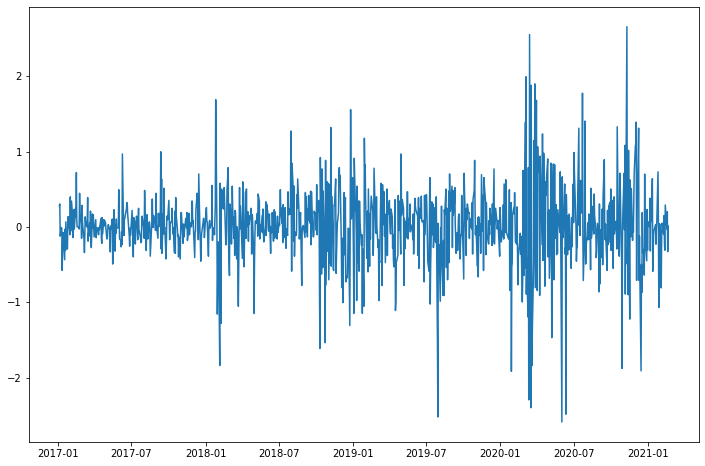

In [25]:
plt.figure(figsize=(12,8))
plt.plot(price_change['Actual_Changes'])

### Price Volatility
Volatility is the range of price change security experiences over a given period of time. If the price stays relatively stable, the security has low volatility. A highly volatile security hits new highs and lows quickly, moves erratically, and has rapid increases and dramatic falls.
For short-term traders, volatility is even more crucial. Day traders work with changes that occur second-to-second, minute-to-minute. If there is no price change, there is no profit.https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp
THe column 'change' shows how volatile the price change percentage wise.  The graph shows that the data points are now centered aound 0. The graph shows that around 3/20 was a volatile period for the stock price and it increase above 7% and decreased 7%.<br>

In [26]:
#calculate historical volatility
prct_change = price_change.copy()
prct_change['change'] = np.log(prct_change['Close'] / prct_change['Close'].shift()) #divide by previous days close

In [27]:
prct_change

,High,Low,Open,Close,Volume,Adj Close,Actual_Changes,change
Date,,,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324,NaN,NaN
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548,0.275143,0.008750
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002,0.303606,0.009567
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008,-0.123341,-0.003875
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928,-0.009487,-0.000299
...,...,...,...,...,...,...,...,...
2021-02-12,34.950001,34.360001,34.439999,34.720001,25513100.0,34.720001,0.290001,0.008388
2021-02-16,34.860001,34.560001,34.849998,34.689999,28668400.0,34.689999,-0.030003,-0.000865
2021-02-17,35.000000,34.459999,34.570000,34.889999,26389400.0,34.889999,0.200001,0.005749


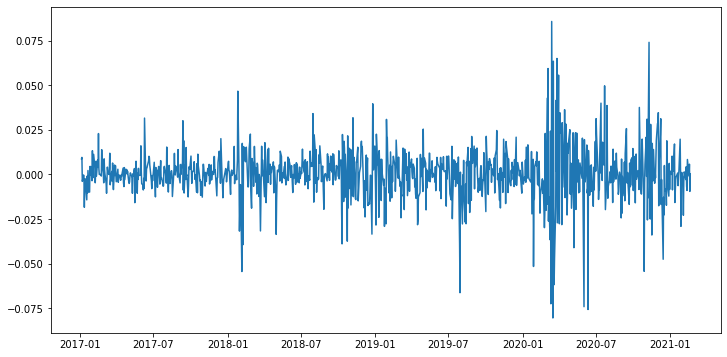

In [28]:
#graph centered around 0
#price only went up 7% twice and around 3/20 went down below 7% a few times
#8/19 went below &%
plt.figure(figsize=(12,6))
plt.plot(prct_change['change'])

### Historical Volatility

In [29]:
#use  rolling standard deviation to get that 
#use 21 day rolling window b/c there are 21 traing days in a month on average
#this will include 21st observation
#but volatility should be used from next day
prct_change['Volatility'] = prct_change['change'].rolling(21).std().shift(1)

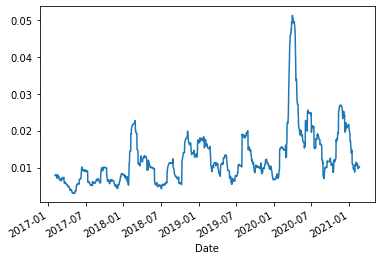

In [30]:
#what price volatility looks like over time
#4/20 was a highly volatile period
prct_change['Volatility'].plot()

In [31]:
#use rolling standard deviation to ge that. Use 21 day rolling window.
#use today's volatility at close today to predcit a 1 std move tomorrow
prct_change['Expected_Change'] = prct_change['Close'].shift(1) * prct_change['Volatility'] #1 std or 21 day rolling std
prct_change = prct_change.iloc[1:]
prct_change

,High,Low,Open,Close,Volume,Adj Close,Actual_Changes,change,Volatility,Expected_Change
Date,,,,,,,,,,
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548,0.275143,0.008750,NaN,NaN
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002,0.303606,0.009567,NaN,NaN
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008,-0.123341,-0.003875,NaN,NaN
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928,-0.009487,-0.000299,NaN,NaN
2017-01-10,31.935484,31.612904,31.869070,31.726755,20444754.0,27.008699,-0.028463,-0.000897,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-02-12,34.950001,34.360001,34.439999,34.720001,25513100.0,34.720001,0.290001,0.008388,0.009753,0.335809
2021-02-16,34.860001,34.560001,34.849998,34.689999,28668400.0,34.689999,-0.030003,-0.000865,0.010023,0.347983
2021-02-17,35.000000,34.459999,34.570000,34.889999,26389400.0,34.889999,0.200001,0.005749,0.010032,0.348003


In [32]:
#magnitude of change
#divide actual change by expected change
#end up w/values in standard deviations
prct_change['Magnitude'] = prct_change['Actual_Changes'] / prct_change['Expected_Change']

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(array([  1.,   2.,   0.,   1.,   2.,   1.,   3.,   4.,   1.,   1.,   5.,
          5.,   6.,  11.,  12.,  21.,  29.,  37.,  61.,  75., 114., 119.,
        101., 104.,  78.,  74.,  53.,  36.,  16.,   9.,  10.,   9.,   1.,
          3.,   3.,   3.,   1.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([-5.34818354, -5.1038373 , -4.85949106, -4.61514482, -4.37079858,
        -4.12645234, -3.8821061 , -3.63775985, -3.39341361, -3.14906737,
        -2.90472113, -2.66037489, -2.41602865, -2.17168241, -1.92733616,
        -1.68298992, -1.43864368, -1.19429744, -0.9499512 , -0.70560496,
        -0.46125872, -0.21691247,  0.02743377,  0.27178001,  0.51612625,
         0.76047249,  1.00481873,  1.24916497,  1.49351122,  1.73785746,
         1.9822037 ,  2.22654994,  2.47089618,  2.71524242,  2.95958866,
         3.2039349 ,  3.44828115,  3.69262739,  3.93697363,  4.18131987,
         4.4256661

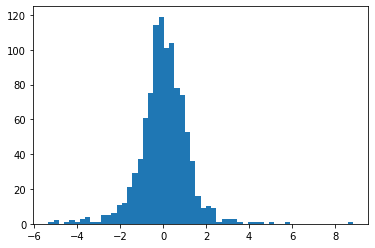

In [33]:
#idea of typical distrubution of changes in terms of standard deviation
#mostly w/in 3 stadnard deviaitons of mean
#could be more of positve change
#kind of equal happening on positve and negative side
plt.hist(prct_change['Magnitude'], bins='auto')

In [34]:

sdr = multi_stocks.pct_change(1)
sdr

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.008788,-0.001640,0.031496,NaN,0.007939,NaN
2017-01-05,0.009612,0.010463,0.007634,NaN,0.027211,NaN
2017-01-06,-0.003868,-0.004792,0.037879,NaN,-0.009062,NaN
2017-01-09,-0.000299,-0.000172,0.036496,NaN,0.003517,NaN
...,...,...,...,...,...,...
2021-02-08,-0.002864,0.002858,0.102523,0.055265,0.006636,0.016416
2021-02-09,0.004308,0.008186,-0.012690,-0.034735,0.006992,-0.016485
2021-02-10,-0.006577,0.003248,-0.055434,-0.001003,-0.008728,0.015485


In [35]:
(26.887548/26.653324) - 1

0.008787796974216056

In [36]:
# #visualize stocks daily returns
# plt.figure(figsize=(12,6))
# #loop through each stock and plot simple returns
# for c in d_simple_returns.columns.values:
#     plt.plot(d_simple_returns.index, d_simple_returns[c], label=c)
# #plt.title(title)
# #plt.ylabel(col + ' Price', fontsize=18)
# plt.legend(loc='upper left', fontsize=10)
# plt.title('Volatility')
# plt.xlabel('Date')
# plt.ylabel('Daily Simple Returns')

## Question 2: How well can historical data and algorithms predict future stocks prices? 
This section focuses on using Long Short Term Memory (LSTM) and SARIMA models to predict future stock prices.

### LTSM Models and LTSM Models with Technical Indicators.



In [37]:
#start='01-01-2019',end='today',
#df_single = single_stock_data('PFE', start='01-01-2019',end='today',plot=True,stock_value='Adj Close')

In [38]:
#df_single.to_csv('single_stock')
single_stock = pd.read_csv('single_stock', parse_dates=True, index_col='Date')
single_stock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,41.271347,40.455406,40.910816,41.034157,26430315.0,37.603287
2019-01-03,41.119545,39.800758,41.024670,39.886147,28503533.0,36.551258
2019-01-04,41.129032,40.094875,40.265656,40.796963,27145348.0,37.385921
2019-01-07,41.385201,40.664139,40.863377,41.015179,20995469.0,37.585892
2019-01-08,41.461102,40.939278,41.328274,41.204933,19677231.0,37.759781
...,...,...,...,...,...,...
2021-02-08,35.009998,34.740002,34.959999,34.820000,31633900.0,34.820000
2021-02-09,35.060001,34.759998,34.799999,34.970001,30170200.0,34.970001
2021-02-10,35.080002,34.700001,35.000000,34.740002,29039900.0,34.740002


In [39]:
(24.905140 / 25.028662) -1

-0.00493522186683415

### LTSM With technical Indicators

In [40]:
# def delta_time_series(data,col=None):
#     data['Percent_Chg'] = data[col].pct_change(1)
    
#     #data_1 = data_1.rename(columns={"Adj Close": "Percent_Chg"})
#     #return data[1:]- data[:-1]
#     data = data.dropna()
#     return data

In [41]:
def delta_time_series(data,col=None):
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [42]:
df_chnge = delta_time_series(single_stock, col='Adj Close')
df_chnge

,High,Low,Open,Close,Volume,Adj Close,Percent_Chg,MA_50
Date,,,,,,,,
2019-03-14,39.924099,39.022770,39.848198,39.079697,32119596.0,36.125008,-0.019519,36.909360
2019-03-15,39.734344,38.766602,39.117645,39.639469,74768652.0,36.642460,0.014324,36.890143
2019-03-18,39.914612,39.516129,39.629982,39.667931,18994345.0,36.668766,0.000718,36.892493
2019-03-19,40.256168,39.611008,39.819733,40.132828,26403227.0,37.098507,0.011720,36.886745
2019-03-20,40.227703,39.639469,40.037952,40.009487,23499035.0,36.984493,-0.003073,36.874717
...,...,...,...,...,...,...,...,...
2021-02-08,35.009998,34.740002,34.959999,34.820000,31633900.0,34.820000,-0.002864,37.223814
2021-02-09,35.060001,34.759998,34.799999,34.970001,30170200.0,34.970001,0.004308,37.200476
2021-02-10,35.080002,34.700001,35.000000,34.740002,29039900.0,34.740002,-0.006577,37.158690


In [43]:
df_chnge.shape

(485, 8)

In [44]:
def plot_delta(data,col=None,symbol=None):
    plt.figure(figsize=(12,6))
    #plt.plot(delta_time_series(data))
    plt.plot(data[col])
    label_font = {'weight':'bold','size':18}
    plt.title('Daily Percentage Price Change',fontdict=label_font)
    plt.xlabel('Dates',fontdict=label_font)
    plt.ylabel('close')
    plt.show()

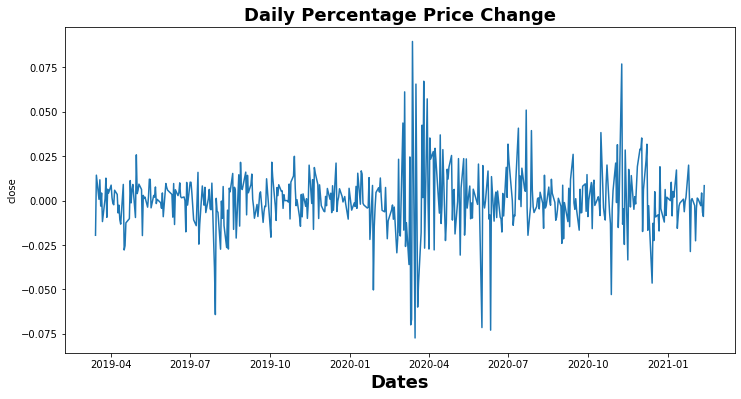

In [45]:
#simple daily return
#centered aroun d 0
plot_delta(df_chnge, col='Percent_Chg')

In [46]:
# def get_y_from_generator(gen):
#     '''
#     Get all targets y from a TimeseriesGenerator instance.
#     '''
#     y = None
#     for i in range(len(gen)):
#         batch_y = gen[i][1]
#         if y is None:
#             y = batch_y
#         else:
#             y = np.append(y, batch_y)
#     y = y.reshape((-1,1))
#     print(y.shape)
#     return y

In [47]:
def get_y_from_df(train_scaled_df, look_back, col='Adj Close', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [48]:
def binary_accuracy(a, b):
    '''
    Helper function to compute the match score of two 
    binary numpy arrays.
    '''
    assert len(a) == len(b)
    return (a == b).sum() / len(a)

In [49]:
df_chnge

,High,Low,Open,Close,Volume,Adj Close,Percent_Chg,MA_50
Date,,,,,,,,
2019-03-14,39.924099,39.022770,39.848198,39.079697,32119596.0,36.125008,-0.019519,36.909360
2019-03-15,39.734344,38.766602,39.117645,39.639469,74768652.0,36.642460,0.014324,36.890143
2019-03-18,39.914612,39.516129,39.629982,39.667931,18994345.0,36.668766,0.000718,36.892493
2019-03-19,40.256168,39.611008,39.819733,40.132828,26403227.0,37.098507,0.011720,36.886745
2019-03-20,40.227703,39.639469,40.037952,40.009487,23499035.0,36.984493,-0.003073,36.874717
...,...,...,...,...,...,...,...,...
2021-02-08,35.009998,34.740002,34.959999,34.820000,31633900.0,34.820000,-0.002864,37.223814
2021-02-09,35.060001,34.759998,34.799999,34.970001,30170200.0,34.970001,0.004308,37.200476
2021-02-10,35.080002,34.700001,35.000000,34.740002,29039900.0,34.740002,-0.006577,37.158690


In [50]:
single_stock = df_chnge.copy()

In [51]:
single_stock

,High,Low,Open,Close,Volume,Adj Close,Percent_Chg,MA_50
Date,,,,,,,,
2019-03-14,39.924099,39.022770,39.848198,39.079697,32119596.0,36.125008,-0.019519,36.909360
2019-03-15,39.734344,38.766602,39.117645,39.639469,74768652.0,36.642460,0.014324,36.890143
2019-03-18,39.914612,39.516129,39.629982,39.667931,18994345.0,36.668766,0.000718,36.892493
2019-03-19,40.256168,39.611008,39.819733,40.132828,26403227.0,37.098507,0.011720,36.886745
2019-03-20,40.227703,39.639469,40.037952,40.009487,23499035.0,36.984493,-0.003073,36.874717
...,...,...,...,...,...,...,...,...
2021-02-08,35.009998,34.740002,34.959999,34.820000,31633900.0,34.820000,-0.002864,37.223814
2021-02-09,35.060001,34.759998,34.799999,34.970001,30170200.0,34.970001,0.004308,37.200476
2021-02-10,35.080002,34.700001,35.000000,34.740002,29039900.0,34.740002,-0.006577,37.158690


In [52]:
train_size = int(len(single_stock) * 0.80)#0.67
test_size = len(single_stock) - train_size
#val_size = len(dataset_delta_AMAZN)  - 

In [53]:
single_stock.index[train_size]

Timestamp('2020-09-25 00:00:00')

In [54]:
single_stock.index[-test_size]


Timestamp('2020-09-25 00:00:00')

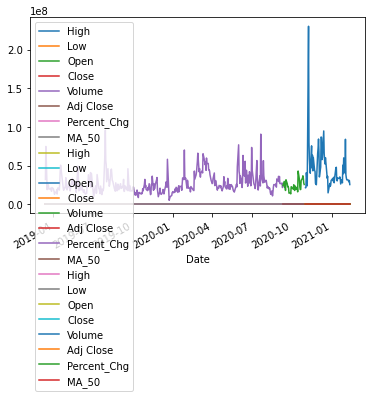

In [55]:
train = single_stock[:'2020-09-11']
val = single_stock['2020-09-11':'2020-11-01']
test = single_stock['2020-11-01':] #2021-02-12
ax = train.plot()
val.plot(ax=ax)
test.plot(ax=ax)

In [56]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot()
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

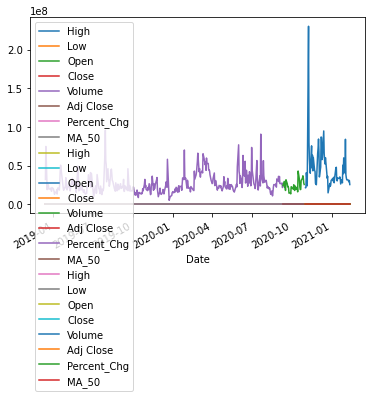

In [57]:
train, val, test= train_test_val(single_stock)

In [58]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
val_scaled = scaler.transform(val)

In [59]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)


In [60]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

((379, 8), (36, 8), (71, 8))

In [61]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

{'High': 0,
 'Low': 1,
 'Open': 2,
 'Close': 3,
 'Volume': 4,
 'Adj Close': 5,
 'Percent_Chg': 6,
 'MA_50': 7}

In [62]:
col_index['Adj Close']


5

In [63]:
train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df['Adj Close'].values,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=batch_size)

In [64]:
val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df['Adj Close'].values,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=batch_size)

In [65]:
test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df['Adj Close'].values,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=3)

In [66]:
ex_X, ex_y = train_data_gen[0]
ex_X.shape

(3, 3, 8)

In [67]:
sample = ex_X[0]
sample.shape

(3, 8)

In [68]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 50)             11800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [69]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

Epoch 1/25
126/126 [==============================] - 2s 12ms/step - loss: 0.0341 - val_loss: 0.0027
Epoch 2/25
126/126 [==============================] - 3s 22ms/step - loss: 0.0109 - val_loss: 0.0081
Epoch 3/25
126/126 [==============================] - 3s 26ms/step - loss: 0.0087 - val_loss: 0.0033
Epoch 4/25
126/126 [==============================] - 3s 26ms/step - loss: 0.0076 - val_loss: 0.0013
Epoch 5/25
126/126 [==============================] - 3s 22ms/step - loss: 0.0079 - val_loss: 0.0023
Epoch 6/25
126/126 [==============================] - 4s 29ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 7/25
126/126 [==============================] - 3s 21ms/step - loss: 0.0065 - val_loss: 0.0011
Epoch 8/25
126/126 [==============================] - 3s 24ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 9/25
126/126 [==============================] - 5s 39ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 10/25
126/126 [==============================] - 3s 26ms/step - loss: 0.0078 - val_lo

In [70]:
model.evaluate_generator(test_data_gen)

0.020083824172616005

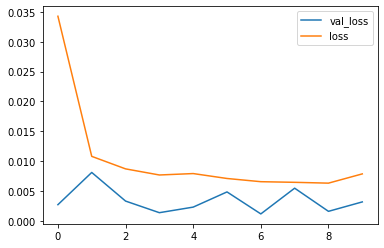

In [71]:
pd.DataFrame(hist.history).plot()

In [72]:
def save_model(model):
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [73]:
model_params = save_model(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 50)             11800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [74]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

(376, 1)

In [75]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

(68, 1)

In [76]:
testPredict

array([[0.5217349 ],
       [0.53898937],
       [0.54474896],
       [0.5184021 ],
       [0.49074897],
       [0.4842005 ],
       [0.61827433],
       [0.61289096],
       [0.59036994],
       [0.5817684 ],
       [0.5636622 ],
       [0.60087675],
       [0.60857207],
       [0.6189541 ],
       [0.62276334],
       [0.6358502 ],
       [0.64460015],
       [0.67289686],
       [0.70320016],
       [0.74069506],
       [0.7934467 ],
       [0.8264155 ],
       [0.84797716],
       [0.87656635],
       [0.8926085 ],
       [0.9009451 ],
       [0.90540165],
       [0.88170165],
       [0.8194773 ],
       [0.73663276],
       [0.70213586],
       [0.68070066],
       [0.66831726],
       [0.657237  ],
       [0.6563317 ],
       [0.66158134],
       [0.6728035 ],
       [0.68201274],
       [0.661984  ],
       [0.6547012 ],
       [0.6433423 ],
       [0.6342923 ],
       [0.6386058 ],
       [0.64755636],
       [0.64847773],
       [0.6543767 ],
       [0.65196127],
       [0.645

In [77]:
trainPredict.shape

(376, 1)

In [78]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

376

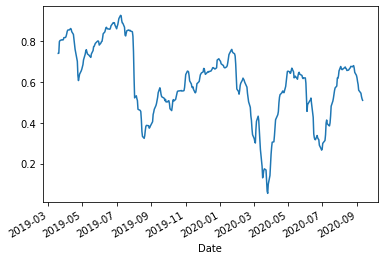

In [79]:
y_hat_train.plot()

In [80]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

68

In [81]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [82]:
def model_metrics(y_train,y_hat_train):
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainScore, testScore

In [83]:
model_metrics(y_train,y_hat_train)

Train Score: 0.06 RMSE
Test Score: 0.18 RMSE


(0.0617873130612963, 0.18255730144371657)

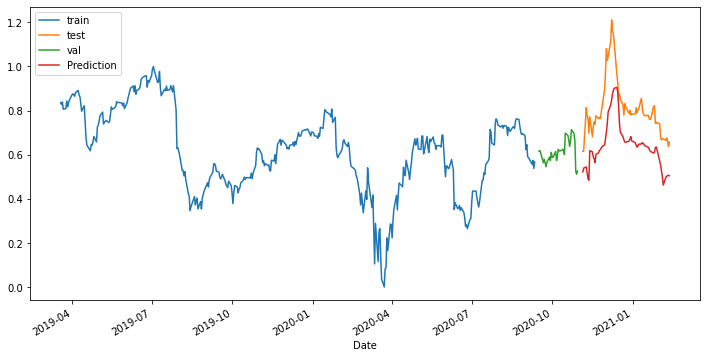

In [84]:
plt.figure(figsize=(12,6))
y_train.plot(label='train')
y_test.plot(label='test')
y_val.plot(label='val')
y_hat_test.plot(label='Prediction')
#lt.legend(['Valid','Train','Predictions'],loc='uppper left')
plt.legend()

### LTSM and Technical Indicators

#### Percent_Chg

In [85]:
col_index['Percent_Chg']

6

In [86]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [87]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Percent_Chg')

In [88]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 50)             11800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)               

In [89]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,callbacks=[early_stop])

Epoch 1/50
126/126 [==============================] - 2s 14ms/step - loss: 0.0251 - val_loss: 0.0349
Epoch 2/50
126/126 [==============================] - 2s 14ms/step - loss: 0.0135 - val_loss: 0.0338
Epoch 3/50
126/126 [==============================] - 1s 11ms/step - loss: 0.0131 - val_loss: 0.0325
Epoch 4/50
126/126 [==============================] - 2s 16ms/step - loss: 0.0128 - val_loss: 0.0364
Epoch 5/50
126/126 [==============================] - 2s 14ms/step - loss: 0.0125 - val_loss: 0.0319
Epoch 6/50
126/126 [==============================] - 1s 11ms/step - loss: 0.0125 - val_loss: 0.0273
Epoch 7/50
126/126 [==============================] - 1s 10ms/step - loss: 0.0127 - val_loss: 0.0331
Epoch 8/50
126/126 [==============================] - 1s 10ms/step - loss: 0.0123 - val_loss: 0.0374
Epoch 9/50
126/126 [==============================] - 1s 10ms/step - loss: 0.0124 - val_loss: 0.0334
Epoch 00009: early stopping


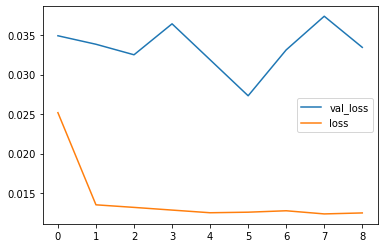

In [90]:
pd.DataFrame(hist.history).plot()

In [91]:
trainPredict = model.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [92]:
model_metrics(y_train,y_hat_train)

Train Score: 0.25 RMSE
Test Score: 0.38 RMSE


(0.25108428654495357, 0.38323051175458855)

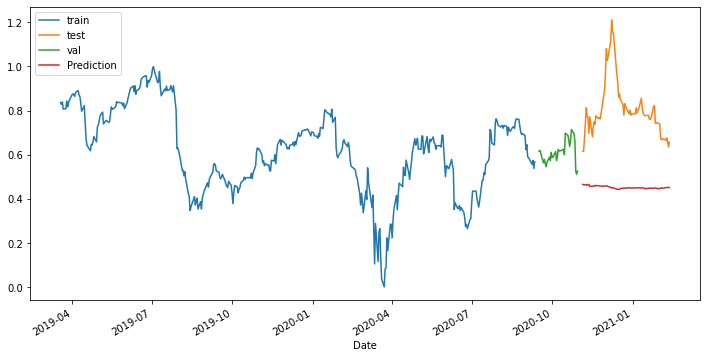

In [93]:
plt.figure(figsize=(12,6))
y_train.plot(label='train')
y_test.plot(label='test')
y_val.plot(label='val')
y_hat_test.plot(label='Prediction')
#lt.legend(['Valid','Train','Predictions'],loc='uppper left')
plt.legend()

In [94]:
def get_quote(new_df):
    #get last 60days closing values and convert datframe to an array
    last_60_days = new_df[-60:].values #converts to array
    #scale data
    last_60_days_scaled = scaler.transform(last_60_days)
    #create empty list
    x_test = []
    #append last 60 days to x_test
    x_test.append(last_60_days_scaled)
    #conert x_test to a numpy array
    x_test = np.array(x_test)
    # #reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    #get the predicted scaled price
    pred_price = model.predict(x_test)
    #undo the scaling 
    pred_price = scaler.inverse_transform(pred_price) 
    #what model thinks predicted price will be for 12/18/2019
    #the actual prcie was $69.94
    #DAL: 58.58, 2021-1-11 40.19
    return pred_price    

In [95]:
#get_quote(single_stock[['Adj Close']])

### Multi-Series Forecasting

Symbols,PFE,JNJ,NVAX,MRNA,AZN
Date,,,,,
2018-12-31,37.951061,122.190071,36.799999,15.270000,35.728897
2019-01-02,37.603287,120.959183,39.400002,15.330000,35.559563
2019-01-03,36.551258,119.037086,40.799999,15.500000,36.058155
2019-01-04,37.385921,121.034927,42.799999,16.959999,36.857777
2019-01-07,37.585892,120.258514,45.200001,16.270000,36.481483
...,...,...,...,...,...
2021-02-12,34.720001,166.580002,289.760010,183.740005,51.689999
2021-02-16,34.689999,165.070007,262.700012,178.529999,50.889999
2021-02-17,34.889999,165.660004,273.980011,176.759995,51.450001


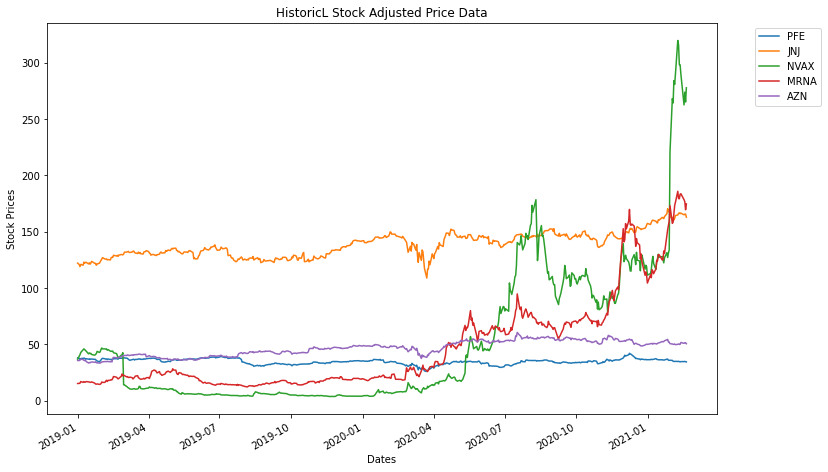

In [96]:
df_multi = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN']], start='12-31-2018',end='today',plot=True, stock_value='Adj Close');
df_multi #;

In [97]:
#len(df_multi), len(dataset_delta_AMAZN)

In [98]:
# dataset_x = delta_time_series(df_multi)
# dataset_x 

In [99]:
dataset_y= delta_time_series(dataset_delta_AMAZN)
dataset_y 

NameError: name 'dataset_delta_AMAZN' is not defined

In [ ]:
# normalize the dataset
scaler_multi = MinMaxScaler(feature_range=(0, 1))
scaler_multi.fit_transform(dataset_x.reshape(-1, 1))
dataset_x = scaler_multi.transform(dataset_x)
dataset_y = scaler_multi.transform(dataset_y)
# split into train and test sets
train_size = int(len(dataset_x) * 0.67)
test_size = len(dataset_x) - train_size
train_x, test_x = dataset_x[0:train_size,:], dataset_x[train_size:len(dataset_x),:]
train_y, test_y = dataset_y[0:train_size,:], dataset_y[train_size:len(dataset_y),:]

In [ ]:
train_x.shape,train_y.shape, test_x.shape, test_y.shape

In [ ]:
train_data_gen = TimeseriesGenerator(train_x, train_y,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=3)

In [ ]:
test_data_gen = TimeseriesGenerator(test_x, test_y,
                               length=look_back, sampling_rate=1,stride=1,
                               batch_size=1)